*Authors:* Ismael Mendoza, Andrii Torchylo, Thomas Sainrat

In this tutorial, we do a deeper dive into the various customization options for the simulation component of BTK.

# Setup

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import btk
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions


from btk.sampling_functions import SamplingFunction
from btk.catalog import CatsimCatalog
from btk.survey import get_surveys
from btk.survey import Filter, Survey
from btk.draw_blends import CatsimGenerator

# Sampling functions

Here, we demonstrate how to use several of the sampling functions that are available within BTK and demonstrate the effect that they have in the output images.

We start by creating an utility function that takes in a sampling function and plots 6 example blends.

In [ ]:
def plot_blends(sampling_function: SamplingFunction):
    _, axes = plt.subplots(2, 3,  figsize=(12, 7))

    # setup
    cat = CatsimCatalog.from_file('../data/input_catalog.fits')
    survey = get_surveys('LSST')

    draw_blends_gen = CatsimGenerator(cat, sampling_function, survey)
    batch = next(draw_blends_gen)

    for ii, ax in enumerate(axes.flat):
        ax.imshow(batch.blend_images[ii, 2], cmap='gray') # r-band
        ax.scatter(batch.catalog_list[ii]["x_peak"],
                    batch.catalog_list[ii]["y_peak"], c="r", marker="x")

    plt.tight_layout()

First, we demonstrate the default density sampling function used in BTK: `DefaultSampling`. This function uniformly at random picks galaxies between `max_number` and `min_number` from the corresponding catalog, and also randomly positions galaxies within `max_shift` distance from the center of each stamp.

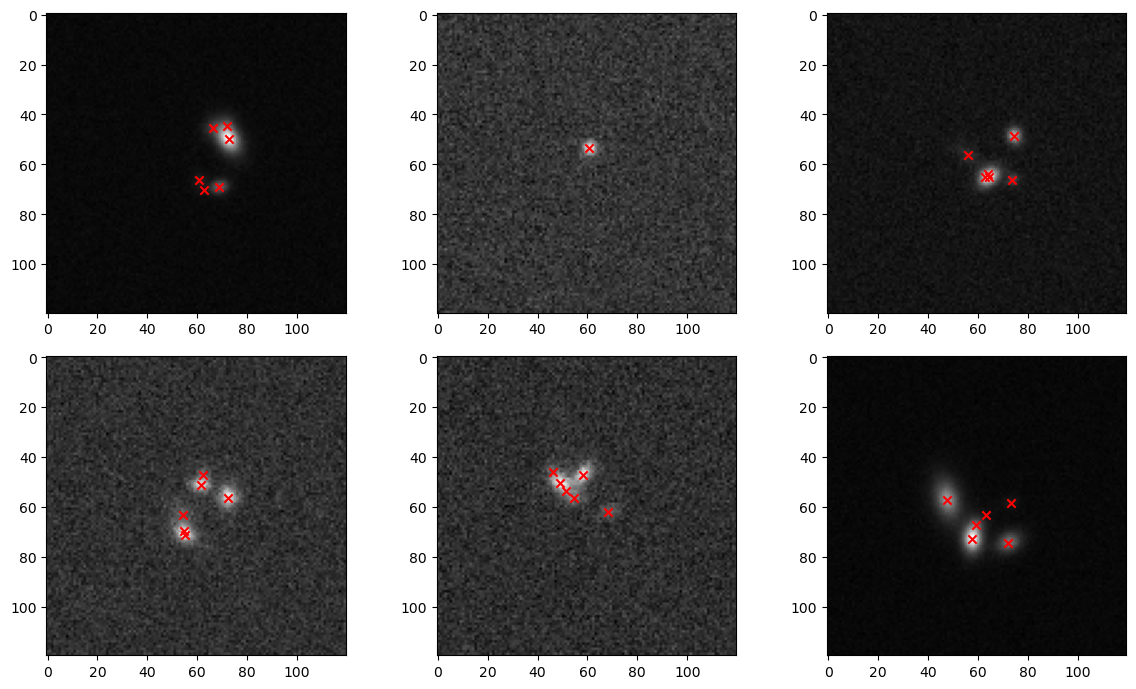

In [ ]:
from btk.sampling_functions import DefaultSampling

sampling_fnc = DefaultSampling(max_number=6, min_number=1, max_shift=3)
plot_blends(sampling_fnc)

Now we demonstrate using the `PairSampling` sampling function, which renders a pair of galaxies in every stamp. The brightest galaxy is always centered exactly in the stamp, and the dim galaxy has a variable uniform distance from the center.

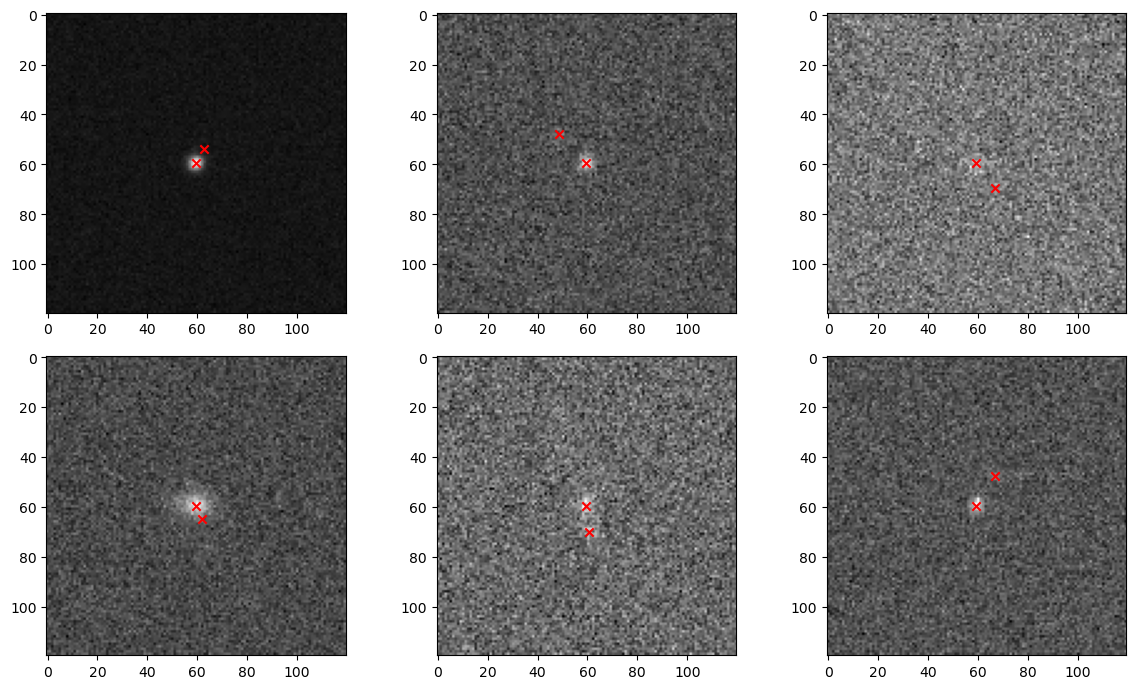

In [ ]:
from btk.sampling_functions import PairSampling

sampling_fnc = PairSampling()
plot_blends(sampling_fnc)

Finally, we demonstrate the `RandomSquareSampling` function, 

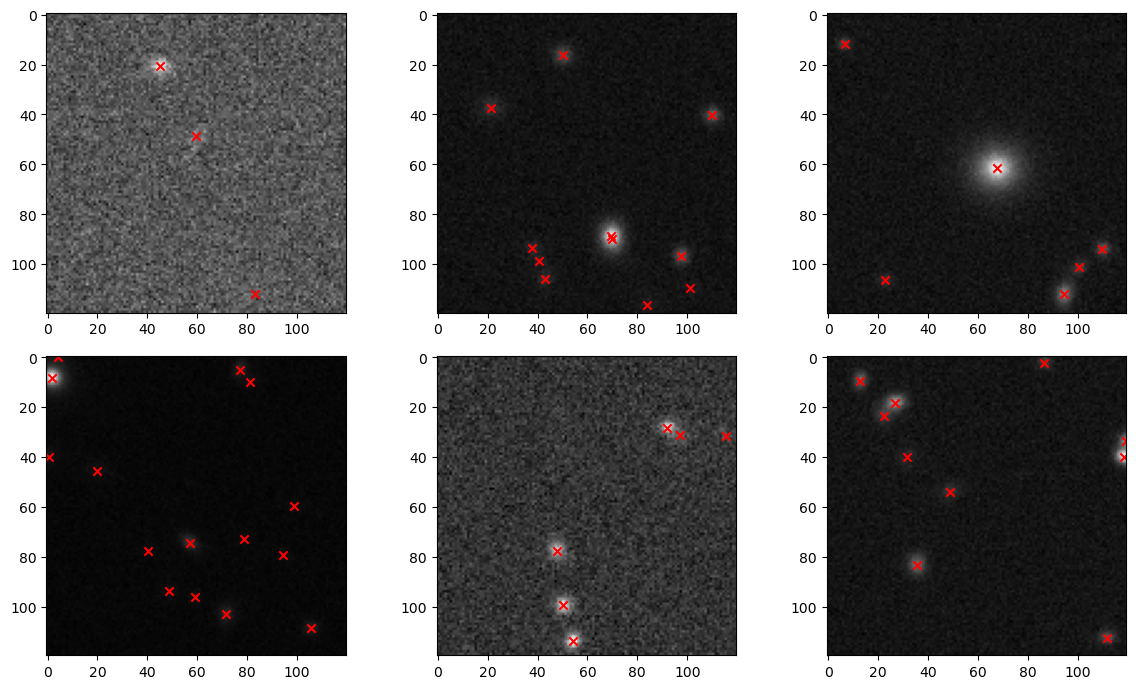

In [ ]:
from btk.sampling_functions import RandomSquareSampling


sampling_fnc = RandomSquareSampling(max_number=30)
plot_blends(sampling_fnc)

In BTK, we currently have a couple of other sampling functions implemented that can be used in the same way as the ones above, and which might be useful depending on your science case: 

* `DensitySampling`: This sampling function randomly selects galaxies to paste in the stamp, and selects the number of galaxies according to the specified density. 

* `FriendsOfFriendsSampling`: This is a more complicated sampling function that uses the FoF algorithm to select groups using the position information from the catalog. Once groups are computed, the sampling function will return one of these groups at random as blends to be rendered.

* `DefaultSamplingShear`: This sampling function works exactly the same as the `DefaultSampling` function, but also adds constant shear information to the catalog that can later be used in the `DrawBlendsGenerator` to draw stamps with some shear applied to the galaxies in them.

## Custom Sampling Function

To write your own sampling function, you should create a subclass of the `SamplingFunction` class available in the `btk.sampling_functions` module, or from one of the classes in that file. 

Below you can find the implementation of the `DefaultSamplingFunction` that is also available in this module (as an example): 

```python
class DefaultSampling(SamplingFunction):
    """Default sampling function used for producing blend catalogs."""

    def __init__(
        self,
        stamp_size: float = 24.0,
        max_number: int = 2,
        min_number: int = 1,
        max_shift: Optional[float] = None,
        seed: int = DEFAULT_SEED,
        max_mag: float = 25.3,
        min_mag: float = -np.inf,
        mag_name: str = "i_ab",
    ):
        super().__init__(stamp_size=stamp_size, max_number=max_number, min_number=min_number, seed=seed)
        self.stamp_size = stamp_size
        self.max_shift = max_shift if max_shift is not None else self.stamp_size / 10.0
        self.min_mag, self.max_mag = min_mag, max_mag
        self.mag_name = mag_name

    def __call__(self, table: Table) -> Table:
        """Take as input a large galaxy catalog, return a random sample of galaxies forming a blend."""
        if self.mag_name not in table.colnames:
            raise ValueError(f"Catalog must have '{self.mag_name}' column.")

        # use `self.rng` for randomness purpose in the sampling function
        # here it is used to determine the total number of objects forming the blend.
        number_of_objects = self.rng.integers(self.min_number, self.max_number + 1)

        # you can enforce additional cuts on the galaxies that you want to be part of a blend too.
        # in this example, we make a cut on the i-band magnitude
        cond = (table[self.mag_name] <= self.max_mag) & (table[self.mag_name] > self.min_mag)
        (q,) = np.where(cond)

        # here we use self.rng again to randomly choose the indices of galaxies that will form our
        # blend. 
        blend_table = table[self.rng.choice(q, size=number_of_objects)]


        # finally, the galaxies centroids are set to uniformly random shfits from the center of 
        # the stamp. In general, centroids should be adjust to be inside the stamp and w.r.t 
        # its center (0,0) in arsecs.
        blend_table["ra"] = 0.0
        blend_table["dec"] = 0.0
        dx, dy = _get_random_center_shift(number_of_objects, self.max_shift, self.rng)
        blend_table["ra"] += dx
        blend_table["dec"] += dy
        _raise_error_if_out_of_bounds(blend_table["ra"], blend_table["dec"], self.stamp_size)
        return blend_table
```


Your new sampling function should have the arguments in its initializer (`__init__`) that are at least the ones contained in the parent `SamplingFunction` class namely: `max_number`, `min_number`, and `seed`. 

It should also implement the `__call__` method, which should take as an argument an `astropy` table corresponding to the full galaxy catalog you are using to produce your simulations and return a smaller `astropy` table corresponding to a subset of the entries which will be the galaxies forming a galaxy blend. Each time the `__call__` method is used, a new blend should be returned and the randomness needed for this should be derived from the random number generator `self.rng`, which ensures reproducibility in BTK. Finally, the positions of galaxies should be adjusted to be inside the postage stamp and w.r.t to its center (0,0). In the example above, we completely overwrite the galaxies centroids and set them to be random shifts from the center of the stamp up to some `self.max_shift`, but there are other ways of implementing this step to preserve some information on the relative positions of galaxies within the catalog. See, for example, `btk.sampling_functions.RandomSquareSampling` sampling function. For more details on implementing a `__call__` method for a sampling function, see the comments in the example above.

# Surveys

The `Survey` class in BTK defines the observational parameters relative to the instrument and telescope making the observation; in particular, it serves to define the pixel scale, the number of bands, the noise level, the flux, and the PSF. 

BTK now relies on an external package named `surveycodex`, which provides two types of objects containing those informations. Here is a brief outline of how they work.

A `Survey` is defined as a Python dataclass, that is a class with some standard methods for accessing the parameters. Most of these parameters are using the astropy unit system. Here are all the fields relevant to BTK that a survey contains:

* `name`: Name of the survey
* `description` : Description of the survey
* `pixel_scale`: Pixel scale in arcseconds
* `effective_area`: Light-collecting area of the telescope; depending on the optics of the telescope this can be different from $\pi \times r^{2}$, in the case of a Schmidt–Cassegrain telescope for instance.
* `mirror_diameter`: Diameter of the primary telescope, in meters (without accounting for an eventual missing area)
* `airmass`: Length of the optical path through atmosphere, relative to the zenith path length. An airmass of 1.2 means that light would travel the equivalent of 1.2 atmosphere when observing.
* `zeropoint_airmass`: airmass which was used when computing the zeropoints. If in doubt, set it to the same value as the airmass.
* `available_filters`: List of the names of the filters for this survey
* `filters`: Dictionary of Filter objects, more on that below. The filters themselves can and should be accessed using the `get_filter` method.

The `Filter` object is, again, a dataclass, containing the informations relative to each filter. A single survey typically contains multiple filters. Each filter contains:

* `name`: Name of the filter
* `sky_brightness`: brightness of the sky background, in mags/sq.arcsec
* `exposure_time`: total exposure time, in seconds
* `zeropoint`: Magnitude of an object giving a measured flux of 1 electron per second
* `extinction`: exponential coefficient describing the absorption of light by the atmosphere.
* `psf`: PSF for the filter. This can be provided in two ways:
    * Providing a `galsim` PSF model, e.g. `galsim.Kolmogorov(fwhm)` or any convolution of such models.
    * Providing a *function* which returns a Galsim model when called (with no arguments). This can be used when you you want to randomize the PSF. In the case of the default settings in BTK, we always use the same constant PSF for each filter in a given survey, computed from the `btk.survey._get_default_psf`. This PSF has an atmospheric and an optical component.

Internally, BTK actually uses its own `Survey` and `Filter` objects, which inherit from the `surveycodex` object. The main difference is that the BTK objects can be modified while the `surveycodex` objects cannot. 

Surveys are usually imported using the `btk.survey.get_surveys` function, which will create the Survey object(s) from surveycodex (currently, the implemented surveys are LSST, HSC, COSMOS, Euclid, DES and CFHT); it is currently difficult to create new surveys. We encourage you to reach out to the BTK or SurveyCodex team on github if creating a new survey would be helpful. 

Here is an example of how parameters can be accessed and modified:

In [ ]:
from astropy import units as u
survey = btk.survey.get_surveys("LSST")
print("Available filters for the LSST survey :",survey.available_filters)
filter_u = survey.get_filter("u")
print("Exposure time for the u band in LSST :",filter_u.full_exposure_time)
filter_u.full_exposure_time = 840.0 * u.s
print("Exposure time for the u band in LSST :",filter_u.full_exposure_time)

Available filters for the LSST survey : ['u', 'g', 'r', 'i', 'z', 'y']
Exposure time for the u band in LSST : 1680.0 s
Exposure time for the u band in LSST : 840.0 s


## Custom PSF

To use your own PSF or a randomized PSF, you can create a function that returns the PSF as a `galsim` object given a `Survey` and `Filter` object. For example: 

In [ ]:
import galsim

def random_psf_size_func(survey:Survey, filter:Filter):
    """Return a Gaussian PSF with random size corresponding to a 50% variation of the default."""
    return galsim.Gaussian(fwhm=filter.psf_fwhm.to_value("arcsec") * np.random.uniform(0.5, 1.5))

Then it can be used:

In [ ]:
survey = get_surveys('LSST', psf_func=random_psf_size_func)

Every batch will then use a new random PSF when using this survey in the `DrawBlendsGenerator`. Below is a quick demonstration: 

In [ ]:
cat = CatsimCatalog.from_file('../data/input_catalog.fits')
sampling_fnc = DefaultSampling(max_number=6, min_number=1, max_shift=3)

draw_blends_gen = CatsimGenerator(cat, sampling_fnc, survey)


batch = next(draw_blends_gen)
print('PSF size for first batch is (r-band):', batch.psf[2].fwhm)

batch = next(draw_blends_gen)
print('PSF size for second batch is (r-band):', batch.psf[2].fwhm)

PSF size for first batch is (r-band): 0.5579667176699447
PSF size for second batch is (r-band): 0.7312409222162884


# COSMOS Galaxies

In this next section, we showcase how to use the COSMOS ['Real' galaxies](https://galsim-developers.github.io/GalSim/_build/html/real_gal.html) within BTK. To start use a different type of catalog that is also available in BTK, the `btk.catalog.CosmosCatalog` and read the corresponding files that are needed to create this object: 

In [ ]:
from btk.catalog import CosmosCatalog

cosmos_files = [
"../data/cosmos/real_galaxy_catalog_23.5_example.fits",
"../data/cosmos/real_galaxy_catalog_23.5_example_fits.fits"
]

cosmos_cat = CosmosCatalog.from_file(cosmos_files)

The catalog contained within this class can be examined:

In [ ]:
cosmos_cat.table[:10]

IDENT_1,MAG,BAND,WEIGHT,GAL_FILENAME,PSF_FILENAME,GAL_HDU,PSF_HDU,PIXEL_SCALE,NOISE_MEAN,NOISE_VARIANCE,NOISE_FILENAME,stamp_flux,IDENT_2,mag_auto,flux_radius,zphot,sersicfit,bulgefit,fit_status,fit_mad_s,fit_mad_b,fit_dvc_btt,use_bulgefit,viable_sersic,hlr,flux,btk_index
int32,float64,bytes5,float64,bytes32,bytes36,int32,int32,float64,float64,float64,bytes26,float64,int32,float64,float64,float64,float64[8],float64[16],int32[5],float64,float64,float64,int32,int32,float64[3],float64[4],int64
100027,20.913000106811523,F814W,0.23257999122142792,real_galaxy_images.fits,real_galaxy_PSF_images.fits,0,0,0.029999999329447746,8.467229781672359e-05,7.455349987139925e-06,acs_I_unrot_sci_20_cf.fits,108.3051217480097,100027,20.913053512573242,14.031698226928711,0.5184000134468079,0.04107378671503146 .. -0.023445131768369355,0.0316924732638154 .. 0.31829637458240845,1 .. 1,0.0026750326807082336,0.0027211891317364886,0.26349168640581294,0,1,0.39359053928423454 .. 0.0,114.39567400214578 .. 0.0,0
100438,22.201000213623047,F814W,0.23222000896930695,real_galaxy_images.fits,real_galaxy_PSF_images.fits,1,1,0.029999999329447746,0.00010393599950475618,7.4736299211508594e-06,acs_I_unrot_sci_20_cf.fits,33.44311959116749,100438,22.200979232788086,13.603924751281738,0.7342000007629395,0.01578905677563159 .. 1.91160971094261,0.01493933423489759 .. -0.0004440736647923771,1 .. 1,0.0029888966204161954,0.0029388059905764777,0.044324963938440945,0,1,0.38209448346035796 .. 0.0,31.99924679153189 .. 0.0,1
100533,20.32200050354004,F814W,0.23687998950481415,real_galaxy_images.fits,real_galaxy_PSF_images.fits,2,2,0.029999999329447746,0.00019905800581909716,8.22513993625762e-06,acs_I_unrot_sci_20_cf.fits,201.04986946238682,100533,20.32219123840332,23.171295166015625,0.22380000352859497,0.03511203544604802 .. 1.4490881213135633,0.03415228318180619 .. 1.6697366023423768,1 .. 1,0.0030970580808755283,0.0031782293617824073,0.10737603633293973,0,1,0.6013317558454855 .. 0.0,187.78195420617482 .. 0.0,2
100791,20.058000564575195,F814W,0.2347399890422821,real_galaxy_images.fits,real_galaxy_PSF_images.fits,3,3,0.029999999329447746,0.00016025500372052193,6.637039859924698e-06,acs_I_unrot_sci_20_cf.fits,236.0436687207548,100791,20.05815887451172,17.304149627685547,0.3122999966144562,0.0656792215621598 .. 1.1052133237365194,0.058359646701952046 .. -1.7315340548399172,1 .. 1,0.004023517718423885,0.003975556501594396,0.0733716848474647,0,1,0.4996177225144924 .. 0.0,243.34457910089543 .. 0.0,3
100914,22.128999710083008,F814W,0.23612001538276672,real_galaxy_images.fits,real_galaxy_PSF_images.fits,4,4,0.029999999329447746,9.832280193222687e-05,9.069870429812e-06,acs_I_unrot_sci_20_cf.fits,33.24559587794511,100914,22.128767013549805,20.705944061279297,0.6808000206947327,0.0019568804884850187 .. 0.0820812923346942,0.0014758288118854697 .. 0.006742219833494747,1 .. 1,0.0032767891235423313,0.002954859532591888,0.6125691915457947,1,1,0.9229527719633837 .. 0.8619243624592441,43.94858857356352 .. 38.648470647298524,4
101602,21.60099983215332,F814W,0.23457999527454376,real_galaxy_images.fits,real_galaxy_PSF_images.fits,6,6,0.029999999329447746,0.0001794059935491532,1.5588599126203917e-05,acs_I_unrot_sci_20_cf.fits,61.196901477349456,101602,21.600902557373047,16.99662208557129,0.9072999954223633,0.007637706589648232 .. 1.2779291606351213,0.010054092223546496 .. 1.4198339956129378,1 .. 1,0.004585946942688416,0.004418037228199764,0.17432032162370598,1,1,0.6695508155121657 .. 0.6083882497806509,71.52102504519827 .. 60.30964341955639,5
101644,22.42799949645996,F814W,0.23043999075889587,real_galaxy_images.fits,real_galaxy_PSF_images.fits,7,7,0.029999999329447746,1.6940599607551121e-06,1.3897500139137264e-05,acs_I_unrot_sci_20_cf.fits,26.772375351254595,101644,22.428218841552734,11.828919410705566,0.8162000179290771,0.011763947996373498 .. 0.13170726644888228,0.010103536424357878 .. -0.12991334804672947,1 .. 1,0.0043051885869458874,0.0035970066572094403,0.23322732965293896,1,1,0.36691190989556033 ..

It only contains a small example from the full COSMOS catalog that is available in the Galsim documentation [site](https://galsim-developers.github.io/GalSim/_build/html/real_gal.html).

We can simulate COSMOS galaxies in any of the BTK available surveys, let's pick LSST again.

In [ ]:
from btk.survey import get_surveys
lsst = get_surveys('LSST')

We again use the default sampling function and we put everything together using a new type of generator: `CosmosGenerator`

In [ ]:
from btk.sampling_functions import DefaultSampling
from btk.draw_blends import CosmosGenerator

sampling_func = DefaultSampling(16, 3, 1,
                                mag_name="MAG" # use the name available in the COSMOS catalog.
                                )

generator = CosmosGenerator(cosmos_cat, sampling_func, lsst, batch_size=9)

Finally, we use the output of the generator to plot some of the COSMOS galaxies:

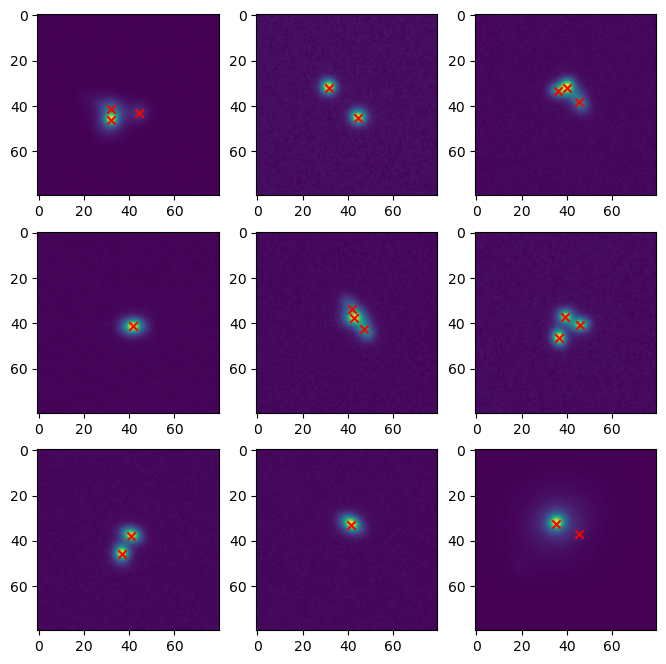

In [ ]:
import matplotlib.pyplot as plt

batch = next(generator)

fig, axes = plt.subplots(3, 3, figsize=(8,8))

for ii in range(batch.batch_size):
    im = batch.blend_images[ii]

    axes.flat[ii].imshow(im[2])

    # plot centers
    axes.flat[ii].scatter(batch.catalog_list[ii]["x_peak"],
                batch.catalog_list[ii]["y_peak"], c="r", marker="x")